In [32]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
from typing import List
plt.style.use('seaborn')

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']

In [4]:
X.shape, y.shape

((70000, 784), (70000,))

In [5]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [6]:
some_digit = X[0]
some_digit.shape

(784,)

In [7]:
some_digit_image = some_digit.reshape(28, 28)

label: 5


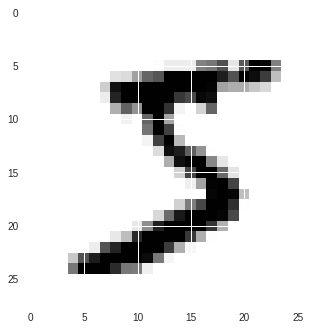

In [8]:
plt.imshow(some_digit_image, cmap='binary');
print(f'label: {y[0]}')

### turn labels from strings to integers

In [9]:
from collections import Counter

Counter(y)

Counter({'5': 6313,
         '0': 6903,
         '4': 6824,
         '1': 7877,
         '9': 6958,
         '2': 6990,
         '3': 7141,
         '6': 6876,
         '7': 7293,
         '8': 6825})

In [10]:
y = y.astype(np.uint8)

### split data into training and test sets

In [11]:
# MNIST dataset is already split into training and test sets 
# first 60_000 samples are training samles and the rest (10_000) are test samples

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [12]:
# testing for 5 and not-5 (binary classification)
y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [13]:
from sklearn.linear_model import SGDClassifier

In [14]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [15]:
sgd_clf.predict([some_digit])

array([ True])

In [16]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=sgd_clf, 
                         X=X_train, 
                         y=y_train_5, 
                         cv=3, 
                         n_jobs=-1, 
                         scoring='accuracy')

In [17]:
scores

array([0.87365, 0.85835, 0.8689 ])

In [18]:
# make prediction on training set using cross validation
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(estimator=sgd_clf, X=X_train, y=y_train_5, cv=3)

In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

### measuring performance

\begin{equation}
precision = \frac{TP}{TP + FP}
\end{equation}

\begin{equation}
recall = \frac{TP}{TP + FN}
\end{equation}

\begin{equation}
F_{1} = \frac{TP}{TP + \frac{FN + FP}{2}}
\end{equation}

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f'precicion: {precision_score(y_train_5, y_train_pred)}')
print(f'recall: {recall_score(y_train_5, y_train_pred)}')
print(f'F1: {f1_score(y_train_5, y_train_pred)}')

precicion: 0.8370879772350012
recall: 0.6511713705958311
F1: 0.7325171197343846


### tradeoff between predicion and recall (based on threshold)

In [26]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

# dicision function score

array([2164.22030239])

In [23]:
threshold = 0
y_some_digit_pred = y_scores > threshold
y_some_digit_pred

array([ True])

In [25]:
threshold = 8000
y_some_digit_pred = y_scores > threshold
y_some_digit_pred

array([False])

In [29]:
y_scores = cross_val_predict(estimator=sgd_clf, 
                             X=X_train, 
                             y=y_train_5, 
                             cv=3, 
                             method='decision_function')

In [31]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [33]:
def plot_precision_recall_vs_threshold(precisions: List[float], 
                                       recalls: List[float], 
                                       thresholds: List[int]):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Thresholds')
    plt.legend()
    plt.show()

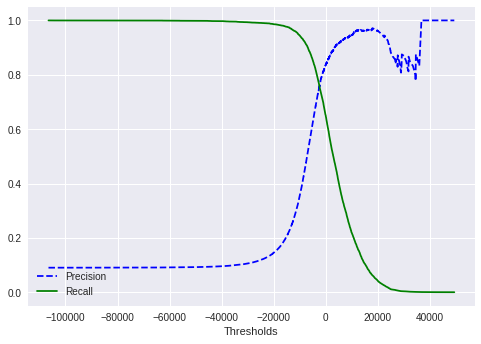

In [34]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [37]:
def plot_precision_vs_recall(precisions: List[float], recalls: List[float]):
    plt.plot(recalls, precisions)
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()

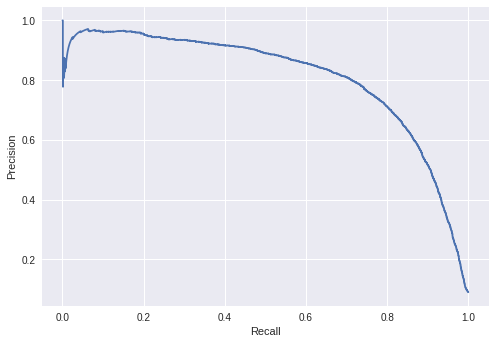

In [38]:
plot_precision_vs_recall(precisions, recalls)

In [40]:
# get value of threshold at which the precision reaches 90%
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
threshold_90_precision

3370.0194991439557

In [41]:
y_train_pred_90 = y_scores >= threshold_90_precision

In [42]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [43]:
recall_score(y_train_5, y_train_pred_90)

## we have 90% precision at 47% recall

0.4799852425751706

### ROC CURVE (Receiver Operating Characteristic)

In [44]:
from sklearn.metrics import roc_curve


fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [45]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.legend()
    plt.xlabel('FPT')
    plt.ylabel('TPR')
    plt.show()

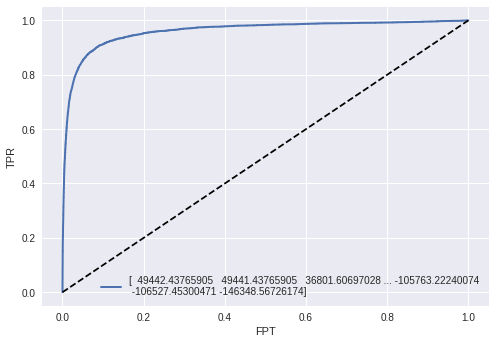

In [47]:
plot_roc_curve(fpr, tpr, thresholds)

### ROC AUC 

In [48]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [51]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(estimator=forest_clf, 
                                    X=X_train, 
                                    y=y_train_5, 
                                    cv=3, 
                                    method='predict_proba', 
                                    n_jobs=-1)

In [52]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [54]:
# let's grab probabilities of positive class, which is the second column in y_probas_forest
# and use it as scores 
y_scores_forest = y_probas_forest[:, 1]

fpr_forest, tpr_forest, thresholds = roc_curve(y_train_5, y_scores_forest)

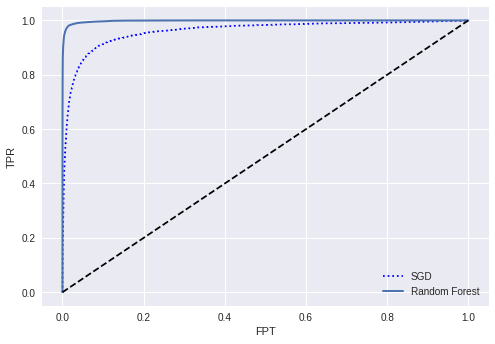

In [57]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')

# RandomForest Classifier is superior to SGD because its ROC curve is closer 
# to the top-left corner and it has greater AUC

In [59]:
# ROC AUC score of random forest classifier
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [62]:
y_pred_forest = cross_val_predict(estimator=forest_clf, 
                                  X=X_train, 
                                  y=y_train_5, 
                                  cv=3, 
                                  n_jobs=-1)

forest_precision = precision_score(y_train_5, y_pred_forest)
forest_recall = recall_score(y_train_5, y_pred_forest)
forest_f1 = f1_score(y_train_5, y_pred_forest)

print(f'forest precision: {forest_precision}')
print(f'forest recall: {forest_recall}')
print(f'forest f1: {forest_f1}')

forest precision: 0.9905083315756169
forest recall: 0.8662608374838591
forest f1: 0.9242275142688446


# MULTICLASS CLASSIFICATION

In [63]:
from sklearn.svm import SVC

# Here we are using Support Vector Classifier, which is strictly binary classifier, to perform
# multiclass classification. Under the hood, sklearn uses OvO (One vs One) method so it trains 
# one classifier per each pair of classes (0 vs 1), (0 vs 2), (0 vs 3) ... => it trains 
# 45 classifiers under the hood and predictions are made by picking the one with the highest 
# probability for a given class

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [66]:
# decision scores for each class 
some_digit_score = svm_clf.decision_function([some_digit])
some_digit_score

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [67]:
# index of the maximum score
np.argmax(some_digit_score)

5

In [68]:
# array of decision classes
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [70]:
# prediction
svm_clf.classes_[np.argmax(some_digit_score)]

5

In [71]:
# forcing OneVsRest
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='scale', kernel='rbf', max_iter=-1,
                                  probability=False, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False),
                    n_jobs=None)

In [74]:
# number of estimators used with OvR is 10 (one per each class)
len(ovr_clf.estimators_)

10

In [75]:
# using SGD for multiclass classificatio
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [76]:
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [77]:
cross_val_score(estimator=sgd_clf, X=X_train, y=y_train, cv=3, n_jobs=-1, scoring='accuracy')

array([0.8731, 0.8775, 0.848 ])

In [79]:
# scaling the value before feeding it into classifier 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(estimator=sgd_clf, 
                X=X_train_scaled, 
                y=y_train, 
                cv=3, 
                n_jobs=-1, 
                scoring='accuracy')

# as we can see, scaling value before feeding them into our classifier has a positive impact
# on the accuracy of the classifier

array([0.89945, 0.8935 , 0.9079 ])

### Error Analysis

In [81]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3, n_jobs=-1)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5589,    0,   23,    6,    9,   58,   39,    6,  192,    1],
       [   0, 6413,   37,   25,    4,   47,    4,    8,  189,   15],
       [  27,   28, 5252,   96,   73,   28,   68,   38,  337,   11],
       [  24,   18,  116, 5257,    2,  224,   28,   40,  350,   72],
       [  12,   15,   49,   12, 5210,   13,   40,   25,  291,  175],
       [  29,   17,   29,  173,   53, 4515,   78,   14,  448,   65],
       [  30,   16,   42,    3,   44,   97, 5568,    4,  113,    1],
       [  20,   10,   54,   33,   51,   14,    3, 5722,  147,  211],
       [  19,   69,   47,   93,    3,  132,   28,   11, 5399,   50],
       [  25,   19,   31,   67,  118,   40,    1,  184,  305, 5159]])

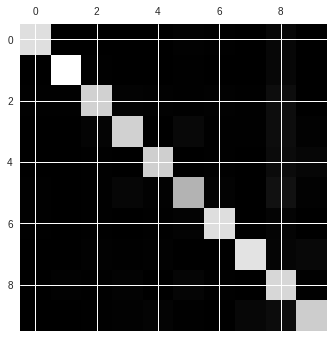

In [82]:
# visualizing confusion matrix
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

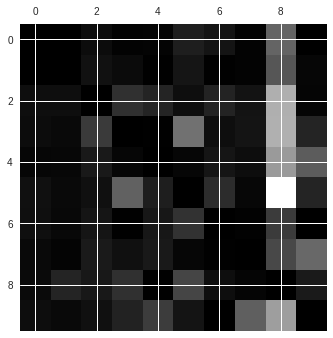

In [84]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

# this tells us that there is no problem with correctly classifying 8 as 8 (rows are actual
# values) but other numbers, most notably 5 are being missclassified as 8.

### multilabel classification

In [85]:
y_train_large = (y_train > 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [86]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [87]:
knn.predict([some_digit])

# this is correct - 5 is not large and it is odd

array([[False,  True]])

In [88]:
y_train_knn_predict = cross_val_predict(estimator=knn, 
                                        X=X_train, 
                                        y=y_multilabel, 
                                        cv=3, 
                                        n_jobs=-1)

In [89]:
f1_score(y_multilabel, y_train_knn_predict, average='macro')

0.9705516699095764